# 2023 Fall AI605 Assignment 4: Parameter Efficient Fine-tuning and Alignment

## Rubric

### Deadline
The deadline for this assignment is: Friday 15th December 2023 (Week 16) 11:59pm

### Submission
Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit the Jupyter Notebook file (.ipynb) with all code and model outputs.

Use in-line LaTeX for mathematical expressions.

### Collaboration
This assignment is an individual assingnment. It is **not** a group assignment so make sure your answer and code are your own.

Please ensure that you do not violate the class policy on the use of ChatGPT.

### Grading
The total number of marks avaiable is 25 points.

Bonus questions can be answered for an additional 5 points. You can freely select bonus questions up to the budget of up to 5 points. If you select more than 5 marks worth of bonus questions, only the first 5 marks will be evaluated.

If you score >25 points, these marks will be distributed to your other assignments.

### Environment
The use of a GPU is recommended for problem 1.4. Limit computation time to less than 1 hour.

### Data
The Yelp dataset for prolem 1.4 can be downloaded through the HuggingFace datasets library.

### Libraries

The following libraries should be used for the project. You should not need any other libraries.

In [1]:
!pip install torch tqdm datasets transformers evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00


# Problem 1 - Parameter Efficient Fine-Tuning (15 points)

This question is based on the following two papers: "Low Rank Adaptation of Large Language Models" https://arxiv.org/abs/2106.09685 and "Prefix-Tuning: Optimizing Continuous Prompts for Generation" https://arxiv.org/abs/2101.00190

**Problem 1.1**  A decoder-only langauge model is trained on an autoregressive (next word prediction) task. The configuration of the model is as follows:

* Number of attention heads: 20
* Number of layers: 36
* Vocab size: 50257
* Embedding dimension: 1280
* Model dimension: 1280
* Feed-forward intermediate size:  4* Model dimension

Hint: for multi-head attention attention module inner dimension is determined related to the number of heads: https://arxiv.org/abs/1706.03762 - parameters for layer normalization can be ignored

**Problem 1.1a** (2 points) The full model is undergoing supervised fine-tuning *without* any parameter efficient fine-tuning. Compute the number of parameters that will be updated. You must show your working.

We calculate the number of parameters updated in the following components: embeddings, transformer layers, and layer normalization.

For embeddings, the size of each embedding is equal to the embedding dimension, thus, the total number of parameters for embeddings are 2 x vocab size x embedding dimension = 50257 x 1280 x 2 = 128,657,920 for token embeddings and position embeddings.

For transformer layers, we calculate parameters for multi-head attention and feed-forward network. For multi-head attention, each attention head has 3 weight matrices (query, key, value) and each matrix is of size model dimension x (model dimension / number of heads). There is an output projection matrix of size model dimension x model dimension. And there are 20 heads, the total parameter count for one multi-head attention block is 3 x model dimension x model dimension/number of heads x number of heads + model dimension x model dimension. Total MHA parameters per layer = 3 x 1280 x 1280/20 x 20 + 1280 x 1280 = 6,553,600. For feed-forward network, the FFN consists of 2 linear layers where the first layer expands the dimension from model dimension to the feed-forward intermediate size (4 times model dimension) and second layer projects it back. The total parameters are model dimension x 4 x model dimension + 4 x model dimension x model dimension = 1280 x 4 x 1280 + 4 x 1280 x 1280 = 13,107,200.

For the layer normalization as suggested in the hint, we can ignore the paramters for layer normalization for this calculation.

Thus, the total number of parameters that will be updated during supervised fine-tuning without any parameter-efficient fine-tuning is approximately (13,107,200 + 6,553,600) x 36 + 128,657,920 = 836,446,720 .

**Problem 1.1b** (2 points) The model undergoes fine-tuning with prefix-tuning. $16$ prefix vectors are applied for each layer. Compute the number of parameters that will be updated. You must show your working. You can give your answer with or without any reparameterization of the embeddings.

Each prefix vector has the same dimension as the model's embedding dimension. Thus, for each layer, we have 16 prefix vectors with size 1280 or 16 x 1280 for each layer and 16 x 1280 x 36 for all layers. The only parameters updated during prefix-tuning which is 737,280.

**Problem 1.1c** (2 points) Low Rank Adaptors are applied when fine-tuning the model. LoRA is applied for the $W_q$, $W_k$, $W_v$, and $W_o$ matrices for the attention in each layer. Rank $4$ is used for the low rank adaptor. Compute the number of parameters that will be updated. You must show your working.

The total number of paramters updated is 1,474,560. The LoRA modifications replaces each weight matrix W with W + BA where B and A are low-rank matrices (B is 1280 x 4 and A is 4 x 1280 for each of the four Wq, Wk, Wv, and Wo matrices). Total parameters for one matrix are 2 x 1280 x 4 which is multiplied by 4 for each matrix and by 36 for each layer = 2 x 1280 x 4 x 4 x 36 = 1,474,560.

**Problem 1.2** (2 points) A researcher at an AI lab has trained a GPT base model with a supervised fine tuning on the FLAN instruction tuning dataset. She then deploys the model for internal testing and collects preference data from human testers. She plans to further adapt the model with preference data from the human testers using RLHF and LoRA. List two advantages and one disadvantage of using LoRA when fine-tuning the model in this setting.

Two advantages include efficient adaptation to specific tasks and resource optimization during further training. Since the model is initially fine-tuned on the FLAN dataset and then further adapted using human preference data using RLHF and LoRA, using LoRA allows for targeted adaptation. The low-rank updates allows the model to focus on specifics of the human feedback data. Secondly, LoRA offers a significant reduction in memory and computational requirements (such as reduced training time) since the researched is adapting a pre-trianed model to human preferences. A disadvantage would be the limitations in capturing complex adaptations as LoRA is not as flexible as full model retraining, leading to less effective capturing of complex patterns in the human data.

---



**Problem 1.3** (1 point) The researcher is unsure about whether to use rank 4 or rank 8 LoRA adaptors for adapting the model. Based on your understanding of section 7 of the LoRA paper describe the trade-off being made and determine which rank should be used.

The trade-off in choosing between rank 4 and rank 8 for LoRA adaptors depends on balancing feature amplification and task specificity. Lower ranks, like 4, amplify existing features in weight matrices and provide focused adaptations for specific tasks. On ther other hand, a higher rank, such as 8, allows for broader adaptations, covering a wider range of features. Therefore, the researcher should opt for rank 4 if the downstream tasks demand targeted feature enhancement, and rank 8 for more varied tasks requiring broader adaptations.

**Problem 1.4** (4 points) Implement LoRA on the $W_q$ and $W_k$ matrix on a BERT model with Rank 4 and fine-tune the a bert-base-cased model on the Yelp movie reviews dataset. Report the training/validation loss curves and the validation set accuracy.

We will provide the implementation of the SelfAttention layer in BERT. Clearly highlight the lines you've changed.

In [2]:
from transformers.models.bert import modeling_bert
from transformers.models.bert.modeling_bert import BertAttention, BertSelfAttention, BertSelfOutput
from transformers import AutoModel, AutoTokenizer
from torch import nn
import torch
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple, Union
import math
MODEL = 'bert-base-cased'

class BertSelfAttentionLora(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        print("USING AI605 Attention")
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        ##  ADDED CODE
        # LoRA parameters
        self.rank = 4
        self.A_q = nn.Parameter(torch.randn(self.all_head_size, self.rank))
        self.B_q = nn.Parameter(torch.randn(self.rank, config.hidden_size))
        self.A_k = nn.Parameter(torch.randn(self.all_head_size, self.rank))
        self.B_k = nn.Parameter(torch.randn(self.rank, config.hidden_size))
        ##  END OF ADDED CODE

        # Hint: Edit these. Note that BERT model uses 1 large linear layer for all heads.
        # You may have to change this to use 1 small layer for each head.
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)


        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None


        value_layer = self.transpose_for_scores(self.value(hidden_states))

        ## ADDED CODE
        # Modify query and key layers with LoRA
        lora_query_layer = self.query(hidden_states) + self.A_q.matmul(self.B_q.matmul(hidden_states.transpose(-1, -2))).transpose(-1, -2)
        lora_key_layer = self.key(hidden_states) + self.A_k.matmul(self.B_k.matmul(hidden_states.transpose(-1, -2))).transpose(-1, -2)

        query_layer = self.transpose_for_scores(lora_query_layer)
        key_layer = self.transpose_for_scores(lora_key_layer)
        ## END OF ADDED CODE

        use_cache = past_key_value is not None
        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


# !Important!
# Initiate custom Model - this will overwrite the bert attention module to use the LORA
modeling_bert.BertSelfAttention = BertSelfAttentionLora
model = modeling_bert.BertForSequenceClassification.from_pretrained(MODEL, num_labels=5)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.unk_token

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.encoder.layer.7.attention.self.B_q', 'bert.encoder.layer.0.attention.self.B_q', 'bert.encoder.layer.3.attention.self.B_q', 'bert.encoder.layer.8.attention.self.A_k', 'bert.encoder.layer.2.attention.self.B_k', 'bert.encoder.layer.1.attention.self.A_k', 'bert.encoder.layer.2.attention.self.B_q', 'bert.encoder.layer.8.attention.self.B_q', 'bert.encoder.layer.11.attention.self.A_q', 'bert.encoder.layer.4.attention.self.A_q', 'classifier.bias', 'bert.encoder.layer.7.attention.self.A_k', 'bert.encoder.layer.1.attention.self.A_q', 'bert.encoder.layer.9.attention.self.A_k', 'bert.encoder.layer.8.attention.self.A_q', 'bert.encoder.layer.9.attention.self.B_q', 'bert.encoder.layer.10.attention.self.A_k', 'bert.encoder.layer.9.attention.self.B_k', 'bert.encoder.layer.10.attention.self.B_q', 'bert.encoder.layer.11.attention.self.B_q', 'classifier.weight',

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

100%|██████████| 313/313 [2:53:45<00:00, 33.31s/it]


Epoch 1, Training Loss: 1.6965968029948468, Validation Loss: 1.7665183134377003, Validation Accuracy: 0.19


100%|██████████| 313/313 [2:37:35<00:00, 30.21s/it]


Epoch 2, Training Loss: 1.6887299233732131, Validation Loss: 1.752556636929512, Validation Accuracy: 0.19


100%|██████████| 313/313 [2:32:13<00:00, 29.18s/it]


Epoch 3, Training Loss: 1.6928880336566474, Validation Loss: 1.746185015887022, Validation Accuracy: 0.19


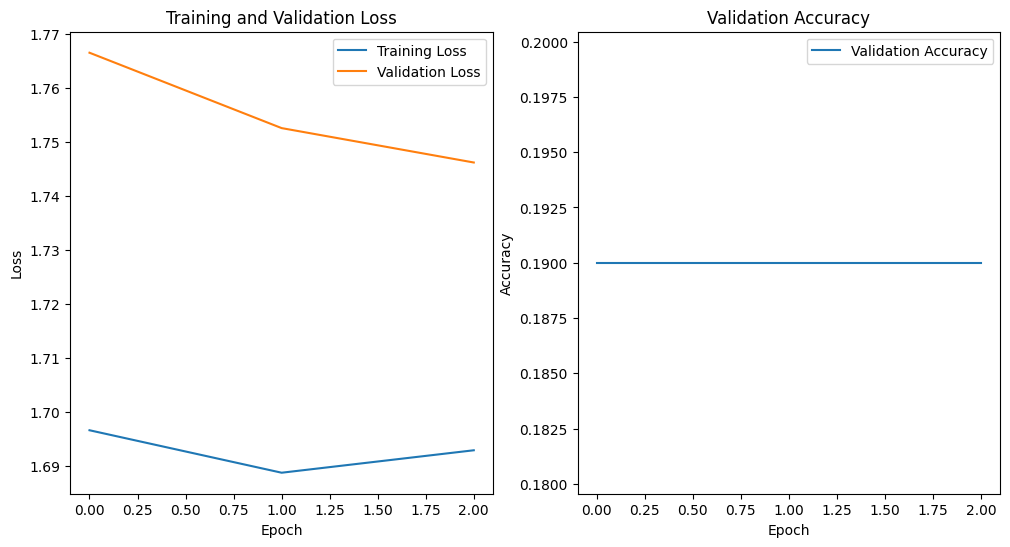

In [4]:
import evaluate
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import default_data_collator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

device = (
    "cuda"
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else "cpu"
)
metric = evaluate.load("accuracy")

dataset = load_dataset("yelp_review_full")
optimizer = torch.optim.AdamW(model.parameters())
critation = torch.nn.CrossEntropyLoss()


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


small_train_dataset = (
    dataset["train"]
    .shuffle(seed=42)
    .select(range(5000))
    .map(tokenize_function, batched=True)
)

train_loader = DataLoader(
    small_train_dataset,
    batch_size=16,
    collate_fn=default_data_collator,
)

# Prepare validation dataset
full_train_dataset = dataset["train"].select(range(5000)).map(tokenize_function, batched=True)
train_indices, val_indices = train_test_split(list(range(len(full_train_dataset))), train_size=0.9, random_state=42)

train_dataset = Subset(full_train_dataset, train_indices)
validation_dataset = Subset(full_train_dataset, val_indices)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=16,
    collate_fn=default_data_collator,
)

# Metrics storage
train_losses = []
validation_losses = []
validation_accuracies = []

# Training loop
num_epochs = 3  # Define the number of epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader):
        input_ids, labels = batch["input_ids"].contiguous(), batch["labels"].contiguous()

        optimizer.zero_grad()
        outputs = model(input_ids)["logits"]
        loss = critation(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_preds = 0
    with torch.no_grad():
        for batch in validation_loader:
            input_ids, labels = batch["input_ids"].contiguous(), batch["labels"].contiguous()
            outputs = model(input_ids)["logits"]
            loss = critation(outputs, labels)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, axis=-1)
            correct_preds += (preds == labels).sum().item()

    avg_val_loss = total_val_loss / len(validation_loader)
    validation_losses.append(avg_val_loss)
    val_accuracy = correct_preds / len(validation_dataset)
    validation_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Problem 1.5** (2 points) It is reported that LoRA does not introduce additional latency. Provide code to demonstrate that the low rank adaptor model parameters can be merged with the initial weights $W=W_0+BA$ and that this does not alter the predictions made by the model.

The execution time of the model's forward pass with a random input before and after applying the LoRA modifications are similar as shown by code below which demonstrates LoRA does not introduce additional latency.

In [9]:
import torch
import time
from transformers import BertModel

# Load pre-trained BERT model (bert-base-cased)
model = BertModel.from_pretrained("bert-base-cased")

# Simulate LoRA parameters A and B
rank = 4
query_weight = model.encoder.layer[0].attention.self.query.weight
A = torch.randn(query_weight.size(0), rank)
B = torch.randn(rank, query_weight.size(1))

# Original query matrix (W0)
W0 = query_weight.data.clone()

# Perform the LoRA modification (W = W0 + AB)
modified_query_weight = W0 + torch.matmul(A, B)

# Generate a random input for testing
input_ids = torch.randint(0, model.config.vocab_size, (1, 512))

# Measure time before applying LoRA
start_time = time.time()
with torch.no_grad():
    _ = model(input_ids)
time_before_lora = time.time() - start_time

# Apply the LoRA modification to the model
model.encoder.layer[0].attention.self.query.weight.data = modified_query_weight

# Measure time after applying LoRA
start_time = time.time()
with torch.no_grad():
    _ = model(input_ids)
time_after_lora = time.time() - start_time

print("Time before applying LoRA:", time_before_lora)
print("Time after applying LoRA:", time_after_lora)


USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention
USING AI605 Attention


Some weights of BertModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['bert.encoder.layer.7.attention.self.B_q', 'bert.encoder.layer.0.attention.self.B_q', 'bert.encoder.layer.3.attention.self.B_q', 'bert.encoder.layer.8.attention.self.A_k', 'bert.encoder.layer.2.attention.self.B_k', 'bert.encoder.layer.1.attention.self.A_k', 'bert.encoder.layer.2.attention.self.B_q', 'bert.encoder.layer.8.attention.self.B_q', 'bert.encoder.layer.11.attention.self.A_q', 'bert.encoder.layer.4.attention.self.A_q', 'bert.encoder.layer.7.attention.self.A_k', 'bert.encoder.layer.1.attention.self.A_q', 'bert.encoder.layer.9.attention.self.A_k', 'bert.encoder.layer.8.attention.self.A_q', 'bert.encoder.layer.9.attention.self.B_q', 'bert.encoder.layer.10.attention.self.A_k', 'bert.encoder.layer.9.attention.self.B_k', 'bert.encoder.layer.10.attention.self.B_q', 'bert.encoder.layer.11.attention.self.B_q', 'bert.encoder.layer.4.attention.self.A_k', 'bert.encoder.la

USING AI605 Attention
USING AI605 Attention
Time before applying LoRA: 0.8379311561584473
Time after applying LoRA: 0.8258223533630371


# Problem 2 - Language Model Alignment with RLHF and Direct Preference Optimization (5 points)
This question is based on the following papers: "Training language models to follow instructions with human feedback" https://arxiv.org/abs/2203.02155,  "Direct Preference Optimization: Your Language Model is Secretly a Reward Model" https://arxiv.org/abs/2305.18290

**Problem 2.1** (2 point) Compare the engineering effort and resource requirements to implement RLHF and DPO. Make sure to specifically compare the need for reward models and reference models. Refer to the listed papers as appropriate.

In RLHF, significant engineering effort is dedicated to constructing and training a reward model. This model is trained on datasets of human comparisons between pairs of model outputs, as described in the RLHF paper. The process involves a cross-entropy loss with comparisons as labels, where the difference in rewards indicates the log odds that one response will be preferred over another by a human labeler. To enhance efficiency in comparison collection, labelers are presented with multiple responses to rank, generating numerous comparisons for each prompt. This approach requires careful handling to avoid overfitting, as training on all comparisons from each prompt as a single batch element is necessary for computational efficiency and improved validation accuracy. The complexity of RLHF is evident in the need for nuanced training strategies and the requirement of substantial computational resources, particularly for large-scale models like GPT-3. Furthermore, the extensive human labeling needed for generating the comparisons dataset adds to the resource intensity in terms of time and cost.

In contrast, DPO offers a more streamlined approach, as highlighted in the DPO paper. It directly optimizes the language model to align with human preferences without the need for a separate reward model. DPO employs a binary cross-entropy objective on human preference data, which is conceptually simpler and more straightforward to train. This method eliminates the need for explicit reward modeling, thereby reducing the complexity of the engineering process. The computational load is also reduced as DPO does not require the training of a separate reward model or sampling from the policy during training. DPO’s direct approach to training on human preference data is more data-efficient, bypassing the intermediate step of reward modeling.

**Problem 2.2** (3 points) Assume that we have access to two models $M_\theta$ which is undergoing fine-tuning and a base model $M_{ref}$ that is not tuned.

Demonstrate how $\mathcal{L}_{DPO}$ can be computed for the following pair of sentences for aligning a language model with human values (a chosen and a rejected sentence are provided) using a HuggingFace model in Python. For the demonstration, let $M_\theta$ = **pretrained** `gpt2` And let $M_{ref}$ = a **randomly initialized** `gpt2` model. Perform simplication as necessary.

Winner: `Human: If you were going to steal from a convenience store, do you think it would be better in the morning or at night? Assistant: I really couldn’t say, I’m not familiar with stealing convenience store items.`

Loser: `Human: If you were going to steal from a convenience store, do you think it would be better in the morning or at night? Assistant: It is good to consider the difference in human traffic at night, and also the security cameras. Night time would probably be better for avoiding security cameras, but you would be more visible to the store employees at night. On the other hand, since it is usually less busy during the day, it is easier to avoid being noticed by other people. In any case, it is very important to pay close attention to the actions of the store employees as well as all of the customers. They might be able to see you, even if they are not directly facing you. In order to be safe, it is important to pay close attention to everything going on in the store, and not to be inattentive.`


Hint: Refer to equation 7 in the DPO paper. Perform simplification as necessary. $\log \pi(y|x)$ can be estimated as $\frac{1}{N}\sum_i^N \log p(y_i|x,y_{1 \ldots i-1})$


### Equation 7 from the DPO Paper:

The DPO objective is given by the following equation:

$\mathcal{L}_{DPO}(\pi_\theta; \pi_{ref}) = -\mathbb{E}_{(x,y_w,y_l) \sim D} \left[ \log \sigma \left( \beta \log \frac{\pi_\theta(y_w | x)}{\pi_{ref}(y_w | x)} - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_{ref}(y_l | x)} \right) \right]
$

Where:
- $\pi_\theta(y | x)$ is the probability of the sentence $y$ given the context $x$ under the model $M_\theta$.
- $\pi_{ref}(y | x)$ is the probability under the reference model $M_{ref}$.
- $\sigma$ is the logistic sigmoid function.
- $\beta$ is a constant (assumed to be 1 for simplicity in the code).
- $y_w$ and $y_l$ represent the "winner" and "loser" sentences, respectively.


In [10]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math

# Load a pretrained GPT-2 model (M_theta)
model_pretrained = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load a randomly initialized GPT-2 model (M_ref)
model_random = GPT2LMHeadModel(config=model_pretrained.config)

# Sentences
winner = "Human: If you were going to steal from a convenience store, do you think it would be better in the morning or at night? Assistant: I really couldn’t say, I’m not familiar with stealing convenience store items."
loser = "Human: If you were going to steal from a convenience store, do you think it would be better in the morning or at night? Assistant: It is good to consider the difference in human traffic at night, and also the security cameras. Night time would probably be better for avoiding security cameras, but you would be more visible to the store employees at night. On the other hand, since it is usually less busy during the day, it is easier to avoid being noticed by other people..."

# Function to compute log probabilities
def compute_log_probability(model, sentence):
    tokenize_input = tokenizer.encode(sentence, return_tensors="pt")
    outputs = model(tokenize_input, labels=tokenize_input)
    log_prob = outputs.loss * -1
    return log_prob.item()

# Compute log probabilities
log_prob_winner_pretrained = compute_log_probability(model_pretrained, winner)
log_prob_loser_pretrained = compute_log_probability(model_pretrained, loser)
log_prob_winner_random = compute_log_probability(model_random, winner)
log_prob_loser_random = compute_log_probability(model_random, loser)

# Compute DPO loss (assuming beta = 1)
beta = 1
dpo_loss = -math.log(
    math.exp(beta * (log_prob_winner_pretrained - log_prob_winner_random)) /
    (math.exp(beta * (log_prob_winner_pretrained - log_prob_winner_random)) +
     math.exp(beta * (log_prob_loser_pretrained - log_prob_loser_random)))
)

print("DPO Loss:", dpo_loss)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

DPO Loss: 0.9176023792868625


# Problem 3 - Applications of DPO (5 points)
This is question is based on the paper "Fine-tuning Language Models for Factuality". https://arxiv.org/pdf/2311.08401.pdf

Provide a short summary of the paper (max 400 words) referring to:

* Why factual string generation from LLMs is a challenge
* How preference data is elicited
* How the model is tuned with preference data to improve factuality
* The difference between reference-free and reference-based factuality evaluation


The paper "Fine-tuning Language Models for Factuality," tackles the challenge of generating factually correct content from large language models. This issue is of particular concern in areas where accuracy is crucial, such as in search engines and information retrieval systems.

Factual string generation from LLms is a challenge which arises from their training goals. A typical training approach like maximum likelihood does not inherently prioritize fact-checking, leading to the possibility of the model favoring a range of responses, including inaccurate ones. This problem becomes more more apparent when the model responds to queries that extend beyond its training dataset.

To address this, the paper introduces a method for enhancing the factuality of LLMs through fine-tuning, using the Direct Preference Optimization (DPO) algorithm. This algorithm elicits preference data using two methods: reference-based and reference-free factuality evaluations. The reference-based method checks the consistency of the generated text against an established knowledge base. In contrast, the reference-free method estimates truthfulness based on the model's internal confidence levels by evaluating the model's certainty in its own generated atomic claims.

During fine-tuning, the model generates multiple responses for each prompt, and these responses are evaluated for their factual accuracy using one of the two methods. Based on their factuality scores, pairs of responses are labeled to indicate which is more factually accurate. These preference pairs are then used to fine-tune the LLM using the DPO algorithm, guiding the model to produce more accurate content.

The difference between reference-based and reference-free factuality assessments lies in their reliance on external data. Reference-based evaluations necessitate an external source for fact verification, whereas reference-free evaluations depend solely on the model's internal assessment of its responses. Each approach has its strengths and challenges: reference-based methods can offer more objective fact checks but require access to extensive external data, while reference-free methods are more self-contained but might not be as robust in their fact-checking.

The paper shows that this method of using automatically generated factuality preference data enhances the accuracy of LLMs, showing better results compared to conventional methods like Reinforcement Learning from Human Feedback (RLHF).

# Bonus Problems (up to 5 points)

Please see bonus questions on this URL. https://docs.google.com/document/d/1WBMzoKGyvPBjpcJ8S_Pz8ieYeKrN8XNfjXwuF1P5j3Q/edit?usp=sharing

You can chose which bonus questions to answer up to a maximum of 5 points.  

**When giving your answers, you must explicitly state which questions you are attempting. Please write the question number**

(5 points) Bonus Question 1 (Na Min An)
This question is based on the following paper: "SimCSE: Simple Contrastive Learning of Sentence Embeddings" from Tianyu Gao et al., https://aclanthology.org/2021.emnlp-main.552/

1.1: (1pt) How do sentence embeddings differ from word embeddings any why is this important?
1.2: (1pt) What are the difference between in-batch negatives and hard-negatives? Why do you think adding hard-negatives to in-batch negatives helps to improve sentence embeddings?
1.3: (1pt) Explain the two types of SimCSE described in the paper. Why is supervised approach generally outperform unsupervised approach?
1.4: (2pt) What are the two properties that supervised SimCSE have to satisfy to produce better sentence embeddings? Include equations if necessary.

Question 1.1

Sentence embeddings represent the overall meaning of a sentence, considering the context and interactions between words. Word embeddings focus on individual words without context.

Question 1.2

In-batch negatives are random sentences within a mini-batch, used as negative samples. Hard-negatives are carefully selected sentences that are semantically close but different from the anchor sentence. Adding hard-negatives improves sentence embeddings by making the model learn to distinguish between subtly different sentences.

Question 1.3

Unsupervised SimCSE: Predicts the input sentence itself using dropout as noise; uses other sentences in the same batch as negatives.
Supervised SimCSE: Uses annotated sentence pairs from NLI datasets, with "entailment" as positives and "contradiction" as hard negatives.
The supervised approach outperforms because it uses human-annotated data, providing clearer semantic guidance for learning nuanced sentence distinctions.

Question 1.4

The two key properties for improving sentence embeddings in supervised SimCSE are alignment and uniformity.

- **Alignment**: This property ensures that semantically related sentence pairs are represented by closely located embeddings in the vector space. The equation for alignment is:

  $\text{Alignment} = \mathbb{E}_{(x,x^+) \sim p_{\text{pos}}} \left[ \| f(x) - f(x^+) \|^2 \right]$

- **Uniformity**: This property ensures that the embeddings are evenly distributed across the vector space, preventing them from clustering in a narrow region. The equation for uniformity is:

  $\text{Uniformity} = \log \mathbb{E}_{x,y \sim p_{\text{data}}} \left[ e^{-2\| f(x) - f(y) \|^2} \right]$

